In [141]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from dotenv import load_dotenv
import os

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")


In [ ]:
# Load existing entries
try:
    existing_df = pd.read_csv("test_run_1.csv")
    entries = existing_df["entries"].tolist() if "entries" in existing_df.columns else [None] * len(df)
except:
    entries = [None] * len(df)

# Find indices that have empty lists (failed entries)
failed_indices = []
for i, entry in enumerate(entries):
    if entry == "[]" or entry is None:
        failed_indices.append(i)

print(f"Found {len(failed_indices)} failed entries to reprocess: {failed_indices}")

# Reprocess only the failed indices
for index in failed_indices:
    try:
        print(f"Reprocessing failed index {index}")
        entries[index] = get_icd10_codes(df.transcript.iloc[index])
        print(f"Successfully processed index {index}")
    except Exception as e:
        print(f"Error reprocessing index {index}: {e}")
        entries[index] = []  # Keep as empty list if it fails again

    # Save after each iteration
    temp_df = df.copy()
    temp_df["entries"] = entries
    temp_df.to_csv("test_run_1.csv", index=False)
    print(f"Saved progress: {failed_indices.index(index) + 1}/{len(failed_indices)} failed entries processed")

Found 0 failed entries to reprocess: []


In [ ]:
# Load existing entries
try:
    existing_df = pd.read_csv("test_run_1.csv")
    entries = existing_df["entries"].tolist() if "entries" in existing_df.columns else [None] * len(df)
except:
    entries = [None] * len(df)

# Find indices that have empty lists (failed entries)
failed_indices = []
for i, entry in enumerate(entries):
    if entry == "[]" or entry is None:
        failed_indices.append(i)

print(f"Found {len(failed_indices)} failed entries to reprocess: {failed_indices}")

# Reprocess only the failed indices
for index in failed_indices:
    try:
        print(f"Reprocessing failed index {index}")
        entries[index] = get_icd10_codes(df.transcript.iloc[index])
        print(f"Successfully processed index {index}")
    except Exception as e:
        print(f"Error reprocessing index {index}: {e}")
        entries[index] = []  # Keep as empty list if it fails again

    # Save after each iteration
    temp_df = df.copy()
    temp_df["entries"] = entries
    temp_df.to_csv("test_run_1.csv", index=False)
    print(f"Saved progress: {failed_indices.index(index) + 1}/{len(failed_indices)} failed entries processed")

Found 0 failed entries to reprocess: []


In [142]:
df = pd.read_csv("test_run_with_confidence.csv")
df.columns

Index(['encounter_id', 'age', 'age_unit', 'sex', 'visit_reason',
       'reference_answer', 'transcript', 'entries', 'confidence_summary',
       'cleaned_transcript'],
      dtype='object')

In [143]:

def get_pred_code(string):
    pred_codes = []
    cond = ast.literal_eval(string)
    for item in cond:
        pred_codes.append(item["icd10_code"])
    return pred_codes

def get_reference_codes(string):
    reference_codes = []
    lines = string.split("\n")
    for l in lines:
        reference_codes.append(l.split(" ")[0])
    return reference_codes

In [144]:
df.reference_answer.iloc[28]

'F32.A Depression with suicidal ideation\nF41.9 Anxiety\nR44.0 Auditory hallucinations\nF43.10 PTSD (post-traumatic stress disorder)'

In [145]:
cond = ast.literal_eval(df.entries.iloc[0])
cond[0]

{'reasoning': 'The patient has type 2 diabetes mellitus that is poorly controlled, with chronic hyperglycemia (A1c ~12%, blood sugars around 200 mg/dL) and previous insulin use. E11.65 specifically denotes type 2 diabetes mellitus with hyperglycemia, which directly applies to this case.',
 'icd10_code': 'E11.65',
 'icd10_condition_name': 'Type 2 diabetes mellitus with hyperglycemia',
 'confidence_reasoning': 'The transcript specifically documents poorly controlled type 2 diabetes with persistent hyperglycemia and A1c ≈ 12%. The code E11.65 directly matches the documented diagnosis and is supported by both the transcript and ICD-10 lookup. No ambiguity.',
 'confidence': 'confident'}

In [146]:
def compute_precision_recall(predicted_codes, reference_codes):
    """
    Compute precision and recall for ICD-10 code predictions
    
    Args:
        predicted_codes: List of predicted ICD-10 codes
        reference_codes: List of reference/ground truth ICD-10 codes
    
    Returns:
        tuple: (precision, recall, f1_score)
    """
    # Convert to sets for easier comparison
    pred_set = set(predicted_codes)
    ref_set = set(reference_codes)
    
    # Calculate true positives (intersection)
    true_positives = len(pred_set.intersection(ref_set))
    
    # Calculate precision: TP / (TP + FP) = TP / total_predicted
    precision = true_positives / len(pred_set) if len(pred_set) > 0 else 0
    
    # Calculate recall: TP / (TP + FN) = TP / total_reference
    recall = true_positives / len(ref_set) if len(ref_set) > 0 else 0
    
    # Calculate F1 score: 2 * (precision * recall) / (precision + recall)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score


In [147]:
index = 2
predicted_codes = get_pred_code(df.entries.iloc[index])
reference_codes = get_reference_codes(df.reference_answer.iloc[index])

# Compute metrics
precision, recall, f1 = compute_precision_recall(predicted_codes, reference_codes)

print(f"Predicted codes: {predicted_codes}")
print(f"Reference codes: {reference_codes}")
print(f"\nMetrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Show which codes matched
matched_codes = set(predicted_codes).intersection(set(reference_codes))
print(f"\nMatched codes: {list(matched_codes)}")
print(f"Missed codes (in reference but not predicted): {list(set(reference_codes) - set(predicted_codes))}")
print(f"Extra codes (predicted but not in reference): {list(set(predicted_codes) - set(reference_codes))}")

Predicted codes: ['F90.9', 'Z51.89']
Reference codes: ['F90.9', 'F91.3']

Metrics:
Precision: 0.500
Recall: 0.500
F1 Score: 0.500

Matched codes: ['F90.9']
Missed codes (in reference but not predicted): ['F91.3']
Extra codes (predicted but not in reference): ['Z51.89']


In [148]:
def evaluate_entire_dataset(df):
    """
    Evaluate precision, recall, and F1 for the entire dataset,
    skipping rows where entries are empty
    """
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    skipped_count = 0
    processed_count = 0
    empty_indices = []  # Track indices of empty entries
    
    for index, row in df.iterrows():
        try:
            # Check if entries is empty or evaluates to empty list
            entries_eval = ast.literal_eval(row['entries'])
            if len(entries_eval) == 0:
                skipped_count += 1
                empty_indices.append(index)  # Store the index
                continue
                
            # Get predicted and reference codes
            predicted_codes = get_pred_code(row['entries'])
            reference_codes = get_reference_codes(row['reference_answer'])
            
            # Compute metrics for this row
            precision, recall, f1 = compute_precision_recall(predicted_codes, reference_codes)
            
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_f1_scores.append(f1)
            processed_count += 1
            
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            skipped_count += 1
            empty_indices.append(index)  # Also track error indices
            continue
    
    # Calculate overall metrics
    avg_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
    avg_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
    avg_f1 = sum(all_f1_scores) / len(all_f1_scores) if all_f1_scores else 0
    
    print(f"Dataset Evaluation Results:")
    print(f"Total rows: {len(df)}")
    print(f"Processed rows: {processed_count}")
    print(f"Skipped rows (empty entries): {skipped_count}")
    print(f"Empty entry indices: {empty_indices}")
    print(f"\nOverall Metrics:")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}")
    
    return {
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1,
        'processed_count': processed_count,
        'skipped_count': skipped_count,
        'empty_indices': empty_indices,  # Added this
        'individual_precisions': all_precisions,
        'individual_recalls': all_recalls,
        'individual_f1_scores': all_f1_scores
    }

# Run the evaluation
results = evaluate_entire_dataset(df)

# You can also access the empty indices directly:
print(f"\nEmpty indices: {results['empty_indices']}")

Dataset Evaluation Results:
Total rows: 33
Processed rows: 33
Skipped rows (empty entries): 0
Empty entry indices: []

Overall Metrics:
Average Precision: 0.393
Average Recall: 0.459
Average F1 Score: 0.398

Empty indices: []


/var/folders/w2/k_w1k3713q94fld1rfljqzdc0000gn/T/ipykernel_90581/698589954.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_df, x='Metric', y='Score',


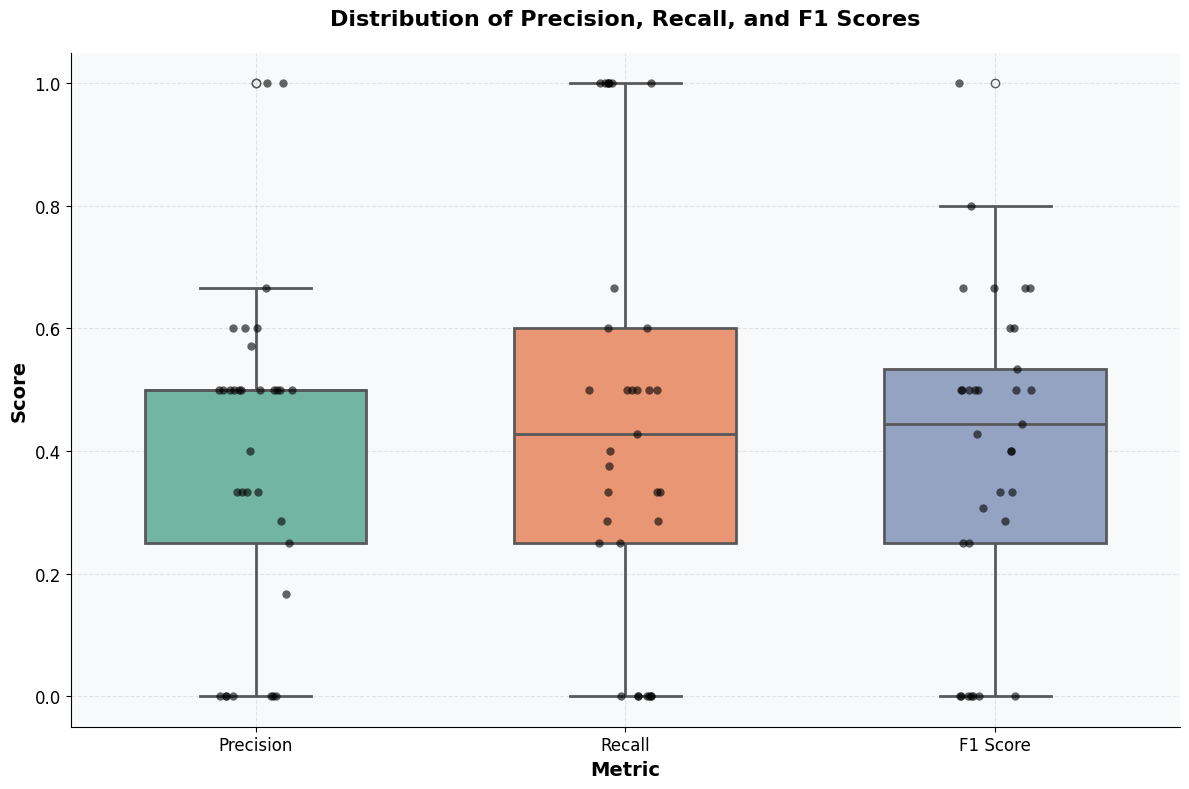


SUMMARY STATISTICS

PRECISION:
  Mean:   0.393
  Median: 0.500
  Std:    0.263
  Range:  0.000 - 1.000
  Count:  33

RECALL:
  Mean:   0.459
  Median: 0.429
  Std:    0.340
  Range:  0.000 - 1.000
  Count:  33

F1 SCORE:
  Mean:   0.398
  Median: 0.444
  Std:    0.256
  Range:  0.000 - 1.000
  Count:  33


In [149]:
# Create a DataFrame from your results for plotting
metrics_data = {
    'Precision': results['individual_precisions'],
    'Recall': results['individual_recalls'], 
    'F1 Score': results['individual_f1_scores']
}

# Convert to long format for seaborn
plot_data = []
for metric, values in metrics_data.items():
    for value in values:
        plot_data.append({'Metric': metric, 'Score': value})

plot_df = pd.DataFrame(plot_data)

# Create the box plot with individual points
plt.figure(figsize=(12, 8))

# Create the box plot with better styling
ax = sns.boxplot(data=plot_df, x='Metric', y='Score', 
                 palette='Set2', width=0.6, linewidth=2)

# Add individual points (strip plot) on top
sns.stripplot(data=plot_df, x='Metric', y='Score', 
              color='black', alpha=0.6, size=6, jitter=True)

# Customize the plot
plt.title('Distribution of Precision, Recall, and F1 Scores', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Metric', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.ylim(-0.05, 1.05)  # Set y-axis limits with some padding

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a subtle background color
ax.set_facecolor('#f8f9fa')

# Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()
plt.show()

# Print summary statistics in a nicer format
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
for metric, values in metrics_data.items():
    print(f"\n{metric.upper()}:")
    print(f"  Mean:   {np.mean(values):.3f}")
    print(f"  Median: {np.median(values):.3f}")
    print(f"  Std:    {np.std(values):.3f}")
    print(f"  Range:  {np.min(values):.3f} - {np.max(values):.3f}")
    print(f"  Count:  {len(values)}")